# Preamble

In [1]:
import numpy as np
import spinmob as s

In [2]:
from sympy import sympify
from scipy.optimize import minimize

In [51]:
from copy import deepcopy

Load in data (1=rigel, 2=joseph, 3=miles) and convert inches to cm:

In [3]:
datafilenames = ["calibration_data"+str(i)+".csv" for i in range(1, 4)]
calibration_datas = [s.data.load(datafilename) for datafilename in datafilenames]
added_voltage_error = 0#0.05
inch_to_cm = 2.54
for calibration_data in calibration_datas:
    calibration_data[0] *= inch_to_cm
    calibration_data[2] *= inch_to_cm
    calibration_data[3] += added_voltage_error

Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: measurements?)
Extra ckey: bad
Extra ckey: to
Extra ckey: due
Extra ckey: 0.003
Extra ckey: to
Extra ckey: up
Extra ckey: take
Extra ckey: (maybe
Extra ckey: errors
Extra ckey: Height


Convert to relative heights:

In [4]:
for calibration_data in calibration_datas:
    calibration_data[0] -= np.max(calibration_data[0])
    calibration_data[0] *= -1
    calibration_data[2] *= np.sqrt(2)

Offset the data for maximal overlap:

In [5]:
second_calibration_offset = -0.0327775555555
third_calibration_offset = -0.0594444444445
calibration_datas[1][0] -= second_calibration_offset
calibration_datas[2][0] -= third_calibration_offset

Chop data so they have some all overlapping:

In [6]:
for calibration_data in calibration_datas:
    max_range = np.argmin(np.abs(calibration_data[0] - 0.45))+1
    for i in range(4):
        calibration_data[i] = calibration_data[i][:max_range]

Generate plots for each:

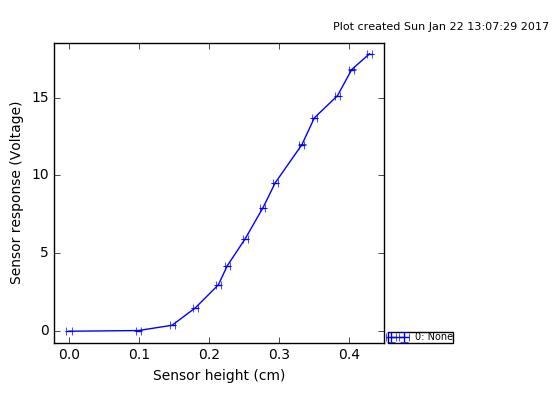

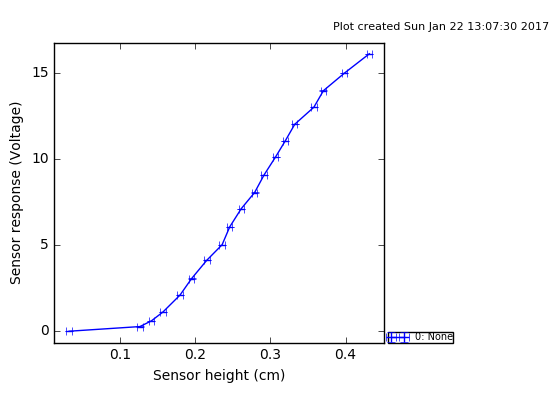

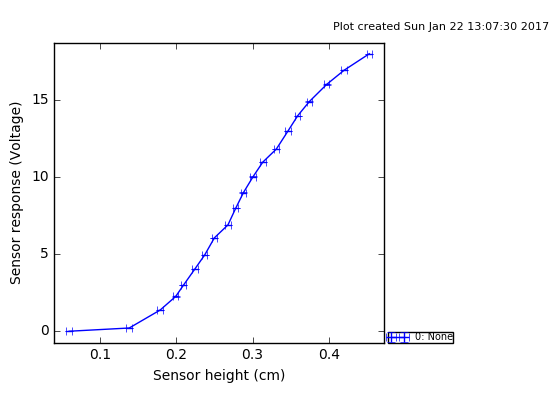

In [7]:
for i, calibration_data in enumerate(calibration_datas):
    fig = s.pylab.figure()
    ax = fig.add_axes([0,0,1,1])
    s.plot.xy.data(
        xdata=calibration_data[0], ydata=calibration_data[1],
        exdata=calibration_data[2], eydata=calibration_data[3],
        xlabel="Sensor height (cm)", ylabel="Sensor response (Voltage)")
    #s.pylab.savefig("calibration_curve"+str(i+1)+".pdf", bbox_inches='tight')

Try to produce some linear fits:

In [80]:
def obtain_fit_results(calibration_data):
    chi_squares = []
    fits = []
    for start in range(0, len(calibration_data[0])-3):
        #print(start, len(calibration_data[0])-start+1)
        for length in range(3, len(calibration_data[0])-start+1):
            my_fitter = s.data.fitter(f='a*x + b', p='a, b')
            my_fitter._settings['autoplot'] = False
            length_of_regression = length
            start_of_regression = start
            end_of_regression = start_of_regression + length_of_regression
            my_fitter.set_data(
                xdata=calibration_data[0][start_of_regression:end_of_regression],
                ydata=calibration_data[1][start_of_regression:end_of_regression],
                exdata=np.zeros(length_of_regression),
                eydata=calibration_data[3][start_of_regression:end_of_regression])
            my_fitter.fit()
            chi_squared = my_fitter.reduced_chi_squareds()[0]
            chi_squares.append([start, length, chi_squared])
            fits.append(my_fitter.results[0])
    return chi_squares, fits

In [29]:
all_fit_data = [obtain_fit_results(calibration_datas[i]) for i in range(3)]
chi_squares = [np.array(all_fit_data[i][0]) for i in range(3)]
best_fits = [np.argsort(np.abs(chi_squares[i][:, 2]-1)) for i in range(3)]
fit_params = [np.array(all_fit_data[i][1]) for i in range(3)]

0 15
1 14
2 13
3 12
4 11
5 10
6 9
7 8
8 7
9 6
10 5
0 20
1 19
2 18
3 17
4 16
5 15
6 14
7 13
8 12
9 11
10 10
0 21
1 20
2 19
3 18
4 17
5 16
6 15
7 14
8 13
9 12
10 11


In [22]:
for i in range(3):
    print("Curve", i)
    for j in range(10):
        print("Start, length, reduced chi-square:", chi_squares[i][best_fits[i][j]])
        pass

Curve 0
Start, length, reduced chi-square: [   6.            3.          117.64611872]
Start, length, reduced chi-square: [   5.     3.   121.5]
Start, length, reduced chi-square: [   4.            4.          185.33898305]
Start, length, reduced chi-square: [   4.            5.          225.33697887]
Start, length, reduced chi-square: [   2.      3.    230.64]
Start, length, reduced chi-square: [   0.            3.          294.23518109]
Start, length, reduced chi-square: [   5.            4.          302.48170366]
Start, length, reduced chi-square: [   4.            7.          323.37672157]
Start, length, reduced chi-square: [   4.            6.          345.33029551]
Start, length, reduced chi-square: [   5.            5.          347.99141492]
Curve 1
Start, length, reduced chi-square: [ 10.           5.          20.96135609]
Start, length, reduced chi-square: [ 10.           4.          29.59417808]
Start, length, reduced chi-square: [  4.           3.          47.04054054]
Start

Include x error in the chi square statistics to get realistic chi-squared values:

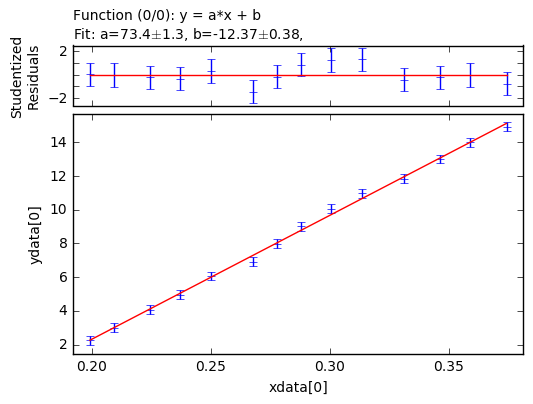

Length: 14.0
Weighted error: 0.263987218942
Chi^2: 0.604783271026


In [50]:
curve_number = 2
for i in range(len(best_fits[curve_number])):
    calibration_datas[curve_number][3][:] = 0.01
    current_slope = fit_params[curve_number][best_fits[curve_number][i]][0]
    
    #Add in errors from measurement
    temp_voltage_error = np.sqrt(
        np.square(calibration_datas[curve_number][3]) + \
        np.square(calibration_datas[curve_number][2]*current_slope))
    total_weighted_error = np.copy(temp_voltage_error)
    
    
    my_fitter = s.data.fitter(f='a*x + b', p='a, b')
    my_fitter._settings['autoplot'] = False
    length_of_regression = chi_squares[curve_number][best_fits[curve_number][i]][1]
    start_of_regression = chi_squares[curve_number][best_fits[curve_number][i]][0]
    end_of_regression = start_of_regression + length_of_regression
    
    my_fitter.set_data(
        xdata=calibration_datas[curve_number][0][start_of_regression:end_of_regression],
        ydata=calibration_datas[curve_number][1][start_of_regression:end_of_regression],
        exdata=np.zeros(length_of_regression),
        eydata=total_weighted_error[start_of_regression:end_of_regression])
    
    if start_of_regression == 3 and length_of_regression == 14:
        my_fitter.fit()
        my_fitter.plot()
        print("Length:", length_of_regression)
        print("Weighted error:", total_weighted_error[0])
        print("Chi^2:", my_fitter.reduced_chi_squareds()[0])
    calibration_datas[curve_number][3][:] = 0.01

## Now, combine the data set:

In [59]:
combined_calibration_data = deepcopy(calibration_datas[0])
for column in range(4):
    combined_calibration_data[column] = deepcopy(
        np.hstack([calibration_datas[i][column] for i in range(3)]))

## Sort the data set according to distance

In [70]:
sort_indices = np.argsort(combined_calibration_data[0])
for column in range(4):
    combined_calibration_data[column] = combined_calibration_data[column][sort_indices]

## Sort the best results:

In [81]:
combined_fit_data = obtain_fit_results(combined_calibration_data)
chi_squares = np.array(combined_fit_data[0])
best_fits = np.argsort(np.abs(chi_squares[:, 2]-1))
fit_params = np.array(combined_fit_data[1])

## Print the best fits:

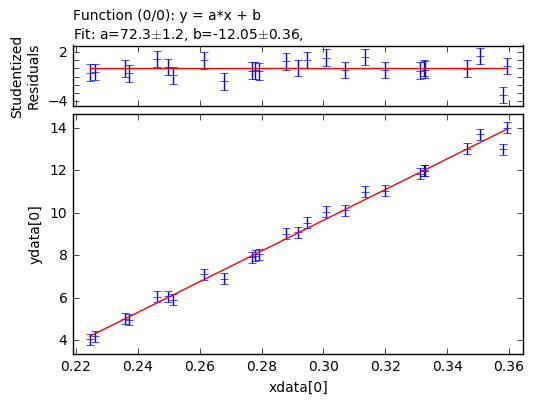

Start: 17.0
Length: 26.0
Weighted error: 0.260001352691
Chi^2: 1.04162134302



In [142]:
max_number_plots = 100
number_plots = 0
for i in range(len(best_fits)):
    current_slope = fit_params[best_fits[i]][0]

    #Add in errors from measurement
    temp_voltage_error = np.sqrt(
        np.square(combined_calibration_data[3]) + \
        np.square(combined_calibration_data[2]*current_slope))
    total_weighted_error = np.copy(temp_voltage_error)


    my_fitter = s.data.fitter(f='a*x + b', p='a, b')
    my_fitter._settings['autoplot'] = False
    length_of_regression = chi_squares[best_fits[i]][1]
    start_of_regression = chi_squares[best_fits[i]][0]
    end_of_regression = start_of_regression + length_of_regression

    my_fitter.set_data(
        xdata=combined_calibration_data[0][start_of_regression:end_of_regression],
        ydata=combined_calibration_data[1][start_of_regression:end_of_regression],
        exdata=np.zeros(length_of_regression),
        eydata=total_weighted_error[start_of_regression:end_of_regression])

    my_fitter.fit()
    if False and length_of_regression > 20 and abs(my_fitter.reduced_chi_squareds()[0]-1) < 0.1:
        
        number_plots += 1
        #my_fitter.plot()
        print("Start:", start_of_regression)
        print("Length:", length_of_regression)
        print("Weighted error:", total_weighted_error[0])
        print("Chi^2:", my_fitter.reduced_chi_squareds()[0])
        print("")
    
    if start_of_regression==17 and length_of_regression==26:
        my_fitter.plot()
        print("Start:", start_of_regression)
        print("Length:", length_of_regression)
        print("Weighted error:", total_weighted_error[0])
        print("Chi^2:", my_fitter.reduced_chi_squareds()[0])
        print("")
    
    if number_plots >= max_number_plots:
        break

# Here I create the plots for our lab.
## I will not use spinmob to do this, as it doesn't feel modular. However, I will use the fits it gave us. 

### Here is the combined to be used:

In [143]:
xdata = np.copy(combined_calibration_data[0])
ydata = np.copy(combined_calibration_data[1])
exdata = np.copy(combined_calibration_data[2])
eydata = np.copy(combined_calibration_data[3])

### Here is a modified version of spinmob's plotting

In [ ]:
from matplotlib import pyplot as plt
# get the data
#xdata, ydata, eydata = self.get_data()
# update settings
#for k in kwargs: self[k] = kwargs[k]

# update the massaged data
#self._massage_data()

results = [72.3, -12.05]
eresults = [1.2, 0.36]

# get the residuals
#r = None
#if not self.results is None: r = self.studentized_residuals(self.results[0])

# get the next figure
fig = plt.figure(self['first_figure'])

# turn off interactive mode
plt.ioff()

fig.clear()

# set up two axes. One for data and one for residuals.
a1 = plt.subplot(211)            # Residuals
a2 = plt.subplot(212, sharex=a1) # Data
a1.set_position([0.15, 0.72, 0.75, 0.15])
a2.set_position([0.15, 0.10, 0.75, 0.60])

# set the scales
a1.set_xscale(self['xscale'][n])
a2.set_xscale(self['xscale'][n])
a2.set_yscale(self['yscale'][n])

#x = self._get_xdata_for_plotting(n=n)

# get the thing to subtract from ydata
if self['subtract_bg'][n] and not self.bg[n] is None:

    # if we have a fit, use that.
    if self.results:
        dy_data = self._evaluate_bg(n, self._xdata_massaged[n], self.results[0])
        dy_func = self._evaluate_bg(n, x,                       self.results[0])

    # otherwise, use the _pguess background
    else:
        dy_data = self._evaluate_bg(n, self._xdata_massaged[n], self._pguess)
        dy_func = self._evaluate_bg(n, x,                       self._pguess)
else:
    dy_data = 0*self._xdata_massaged[n]
    dy_func = 0*x


# add the data to the plot
if self['plot_ey'][n]:
    a2.errorbar(self._xdata_massaged[n],
                self._ydata_massaged[n]-dy_data,
                self._eydata_massaged[n],
                **self['style_data'][n])
else:
    a2.plot(    self._xdata_massaged[n],
                self._ydata_massaged[n]-dy_data,
                **self['style_data'][n])

# set the plot range according to just the data
_s.tweaks.auto_zoom(axes=a2, draw=False)
a2.set_autoscale_on(False)

# add the _pguess curves
y_guess = self._evaluate_f(n,x,self._pguess)-dy_func
if self['plot_guess'][n]:

    # plot the _pguess background curve
    if self['plot_bg'][n] and self.bg[n] is not None:
        a2.plot(x, self._evaluate_bg(n,x,self._pguess)-dy_func, **self['style_guess'][n])

    # plot the _pguess main curve
    a2.plot(x, y_guess, **self['style_guess'][n])

# add the fit curves (if we have a fit)
if self['plot_fit'] and self.results:

    # plot the background curve
    if self['plot_bg'][n] and self.bg[n] is not None:
        a2.plot(x, self._evaluate_bg(n,x,self.results[0])-dy_func, **self['style_fit'][n])

    # plot the pfit main curve
    a2.plot(x, self._evaluate_f(n,x,self.results[0])-dy_func, **self['style_fit'][n])

a2.set_autoscale_on(True)

# plot the residuals
if self.results is not None:
    a1.errorbar(self._xdata_massaged[n], r[n], _n.ones(len(r[n])),             **self['style_data'][n])
    a1.plot([min(self._xdata_massaged[n]),max(self._xdata_massaged[n])],[0,0], **self['style_fit'][n])
    _s.tweaks.auto_zoom(axes=a1, draw=False)

# otherwise plot the guess residuals
elif self['plot_guess'][n]:
    a1.errorbar(self._xdata_massaged[n], r[n], _n.ones(len(r[n])),             **self['style_data'][n])
    a1.plot([min(self._xdata_massaged[n]),max(self._xdata_massaged[n])],[0,0], **self['style_guess'][n])
    _s.tweaks.auto_zoom(axes=a1, draw=False)


# Tidy up
yticklabels = a1.get_yticklabels()
for m in range(2,len(yticklabels)-2): yticklabels[m].set_visible(False)
for m in a1.get_xticklabels(): m.set_visible(False)

# Add labels to the axes
if self['xlabel'][n] is None: plt.xlabel('xdata['+str(n)+']')
else:                         plt.xlabel(self['xlabel'][n])
if self['ylabel'][n] is None:
    ylabel='ydata['+str(n)+']'
    if self['subtract_bg'][n] and self.bg[n] is not None:
        ylabel=ylabel+' - bg['+str(n)+']'
    plt.ylabel(ylabel)
else:                         plt.ylabel(self['ylabel'][n])
a1.set_ylabel('Studentized\nResiduals')

# Assemble the title
wrap = 80
indent = '      '
t = _textwrap.fill('Function ('+str(n)+'/'+str(len(ydata)-1)+'): y = '+self._fnames[n], wrap, subsequent_indent=indent)

if len(self._cnames):
    t1 = "Constants: "
    for i in range(len(self._cnames)):
        t1 = t1 + self._cnames[i] + "={:G}, ".format(self._constants[i])
    t = t + '\n' + _textwrap.fill(t1, wrap, subsequent_indent=indent)

if self.results and not self.results[1] is None:
    t1 = "Fit: "
    for i in range(len(self._pnames)):
        t1 = t1 + self._pnames[i] + "={:s}, ".format(self._format_value_error(self.results[0][i], _n.sqrt(self.results[1][i][i]), '$\pm$'))
    t = t + '\n' + _textwrap.fill(t1, wrap, subsequent_indent=indent)

elif self.results:
    t1 = "Fit did not converge: "
    for i in range(len(self._pnames)):
        t1 = t1 + self._pnames[i] + "={:8G}$, "
    t = t + '\n' + _textwrap.fill(t1, wrap, subsequent_indent=indent)

a1.set_title(t, fontsize=10, ha='left', position=(0,1))

# if we're supposed to plot the guess and zoom to include it
if self['plot_guess_zoom'][n]:
    ymin, ymax = a2.get_ylim()
    a2.set_ylim(min(ymin,min(y_guess)),
                max(ymax,max(y_guess)))


# turn back to interactive and show the plots.
plt.ion()
plt.draw()
plt.show()
